# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [12]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [13]:
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline
#from dqn_agent import Agent
from model import QNetwork

In [14]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Initialize timestep
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
       
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [15]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [16]:
#def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.98, train=True):
def dqn(n_episodes=1000, max_t=10000, eps_start=0.5, eps_end=0.01, eps_decay=0.98, train=True):

    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for n in range(1, n_episodes+1):
        #state = env.reset()
        score = 0                                          # set score to 0                                   
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state        

        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0) # get an action
            env_info = env.step(action)[brain_name]          # send the action to the environment 
            #print(env_info)
            next_state = env_info.vector_observations[0]     # get the next state 
            reward = env_info.rewards[0]                     # get the reward  
            done = env_info.local_done[0]                    # get if the episode has finished

            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # go the next state
            if done:                                       # if it's done --> exit the loop 
                break 
        scores_window.append(score)                        # save the most recent score to the memory (ReplayBuffer)
        scores.append(score)                               # save the most recent score
        eps = max(eps_end, eps_decay*eps)                  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(n, np.mean(scores_window)), end="")  #print episodes and Average score
        if n % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(n, np.mean(scores_window)))
        if np.mean(scores_window)>=13:                     # if average score is higher than 13, we are done! 
           # print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(n-100, np.mean(scores_window)))
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(n, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model1.pt') # save the weights to a checkpoint file
            break
    return scores

In [17]:
#agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent = Agent(state_size=37, action_size=4, seed=0)
scores = dqn() #eps_decay=0.93 buenos resultados

Episode 100	Average Score: 3.73
Episode 200	Average Score: 8.99
Episode 300	Average Score: 13.01

Environment solved in 300 episodes!	Average Score: 13.01


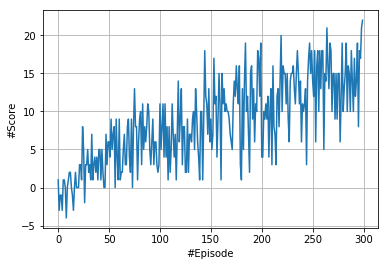

In [18]:
# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('#Score')
plt.xlabel('#Episode')
plt.grid(True)
plt.show()

In [ ]:
#Let's see the agent acting, after it has learnt

In [19]:
## Create the environment
try:
    env
except:
    env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

    # Get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # Get the environment info
    env_info = env.reset(train_mode=False)[brain_name]
    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)

    ## Create the DQN Agent
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    #agent = Agent(state_size=37, action_size=4, seed=0)

## Load the saved model
state_dict = torch.load('model1.pt')
agent.qnetwork_local.load_state_dict(state_dict)
agent.qnetwork_local.eval()


n_episodes = 5
max_t = 300

## Train the Agent
scores = []       # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
for i_episode in range(1, n_episodes+1):
    state = env.reset(train_mode=False)[brain_name].vector_observations[0]
    score = 0
    for t in range(max_t):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        state = next_state
        score += reward
        #print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window)))
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
        if done:
            break 

    scores.append(score)              # save most recent score        
    scores_window.append(score)                        # save the most recent score to the memory (ReplayBuffer)          
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))    

Episode 1	Average Score: 13.00
Episode 2	Average Score: 13.50
Episode 3	Average Score: 12.67
Episode 4	Average Score: 13.25
Episode 5	Average Score: 13.60


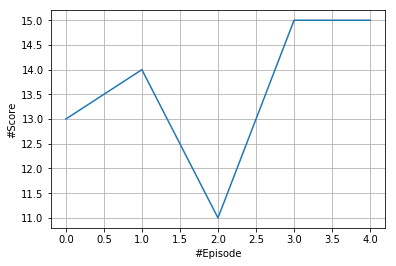

In [20]:
# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_window)), scores_window)
plt.ylabel('#Score')
plt.xlabel('#Episode')
plt.grid(True)
plt.show()

In [21]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from my_dqn_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

# please do not modify the line below
#env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

In [22]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [23]:
def dqn(n_episodes=2000, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.98):
#def dqn(n_episodes=2300, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.98):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #print('Empiezo el dqn')
    scores = []                                            # list containing scores from each episode
    scores_window = deque(maxlen=100)                      # last 100 scores
    eps = eps_start                                        # initialize epsilon    
        
    for n in range(1, n_episodes+1):
        #print('\rVoy por ',n)
        #env_info = env.reset(train_mode=True)[brain_name]
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        for t in range(max_t):
            #print('\rY entro en ',t)
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            reward = env_info.rewards[0]                   # get the reward
            next_state = env_info.vector_observations[0]   # get the next state
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_window.append(score)                        # save most recent score
        scores.append(score)                               # save most recent score
        eps = max(eps_end, eps_decay*eps)                  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(n, np.mean(scores_window)), end="")
        if n % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(n, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(n, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model2.pt')
            break 
            
    return scores

#scores = dqn()

In [24]:
# initialize my agent
agent = Agent(state_size=37, action_size=4, seed=0, duel=False, prioritize=False)

In [25]:
# initialize my agent
scores = dqn() 

Episode 100	Average Score: 0.65
Episode 200	Average Score: 2.28
Episode 300	Average Score: 8.74
Episode 400	Average Score: 10.72
Episode 445	Average Score: 13.03
Environment solved in 445 episodes!	Average Score: 13.03


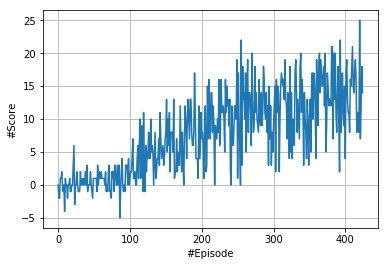

In [30]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('#Score')
plt.xlabel('#Episode')
plt.grid(True)
plt.show()

In [30]:
# initialize my agent
agent = Agent(state_size=37, action_size=4, seed=0, duel=True, prioritize=False)
scores = dqn() 

Episode 100	Average Score: 0.16
Episode 200	Average Score: 1.76
Episode 300	Average Score: 4.36
Episode 400	Average Score: 5.33
Episode 500	Average Score: 6.94
Episode 600	Average Score: 11.30
Episode 677	Average Score: 13.00
Environment solved in 677 episodes!	Average Score: 13.00


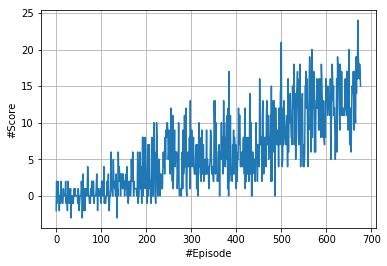

In [31]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('#Score')
plt.xlabel('#Episode')
plt.grid(True)
plt.show()

In [32]:
# initialize my agent
agent = Agent(state_size=37, action_size=4, seed=0, duel=False, prioritize=True)
scores = dqn() 

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.06
Episode 300	Average Score: 0.21
Episode 400	Average Score: 0.58
Episode 500	Average Score: 2.07
Episode 600	Average Score: 5.28
Episode 700	Average Score: 5.03
Episode 800	Average Score: 8.20
Episode 900	Average Score: 10.65
Episode 1000	Average Score: 12.27
Episode 1100	Average Score: 12.86
Episode 1107	Average Score: 13.08
Environment solved in 1107 episodes!	Average Score: 13.08


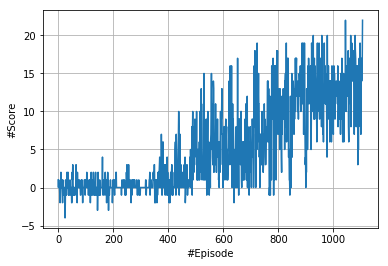

In [33]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('#Score')
plt.xlabel('#Episode')
plt.grid(True)
plt.show()

In [18]:
# initialize my agent
agent = Agent(state_size=37, action_size=4, seed=0, duel=True, prioritize=True)
scores = dqn()

Episode 100	Average Score: 0.14
Episode 200	Average Score: 0.45
Episode 300	Average Score: 0.94
Episode 400	Average Score: 2.73
Episode 500	Average Score: 6.07
Episode 600	Average Score: 9.84
Episode 700	Average Score: 11.00
Episode 800	Average Score: 10.72
Episode 900	Average Score: 10.82
Episode 1000	Average Score: 9.30
Episode 1100	Average Score: 10.52
Episode 1200	Average Score: 11.26
Episode 1300	Average Score: 12.41
Episode 1400	Average Score: 11.25
Episode 1477	Average Score: 13.09
Environment solved in 1477 episodes!	Average Score: 13.09


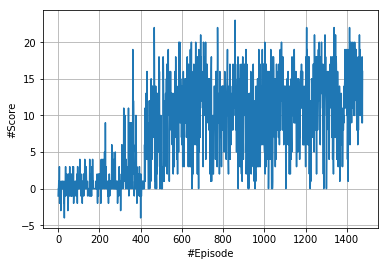

In [19]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('#Score')
plt.xlabel('#Episode')
plt.grid(True)
plt.show()

In [13]:
env.close()